This is the IBM SIR pipeline.

In [41]:
import os

import time

import numpy as np

from scipy.spatial.distance import pdist, squareform

import networkx as nx

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

In [42]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 20  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 28  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 28  # Font size of titlea

plt.rcParams['legend.fontsize'] = 20



# Covariates simulation

In [43]:
N_pop = 1000

# Spatial SIR

In [44]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [45]:
index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N_pop], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)
observed_index = tf.concat((tf.ones(500), tf.zeros(500)), axis = 0)

In [46]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([3.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.05], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.1], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([1.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2, 0.5], dtype = tf.float32))}

SIR = spatial_SIR(locations, covariates, observed_index)


In [47]:
T    = 100

tf.random.set_seed((123))
np.random.seed((123))

start = time.time()
X_spatial, Y_spatial = simulator(SIR, parameters, T, seed_sim = 123)
print(time.time()-start)

X_spatial, Y_spatial = X_spatial[:,0,...], Y_spatial[:,0,...]

1.7355999946594238


In [48]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [49]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([1.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([0.0], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([3], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32))}

learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":3} 

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

loss_tensor, parameters_tensor = CAL_inference(SIR, par_to_upd, Y_spatial, learning_parameters, optimizer, n_gradient_steps, initialization = "parameters")

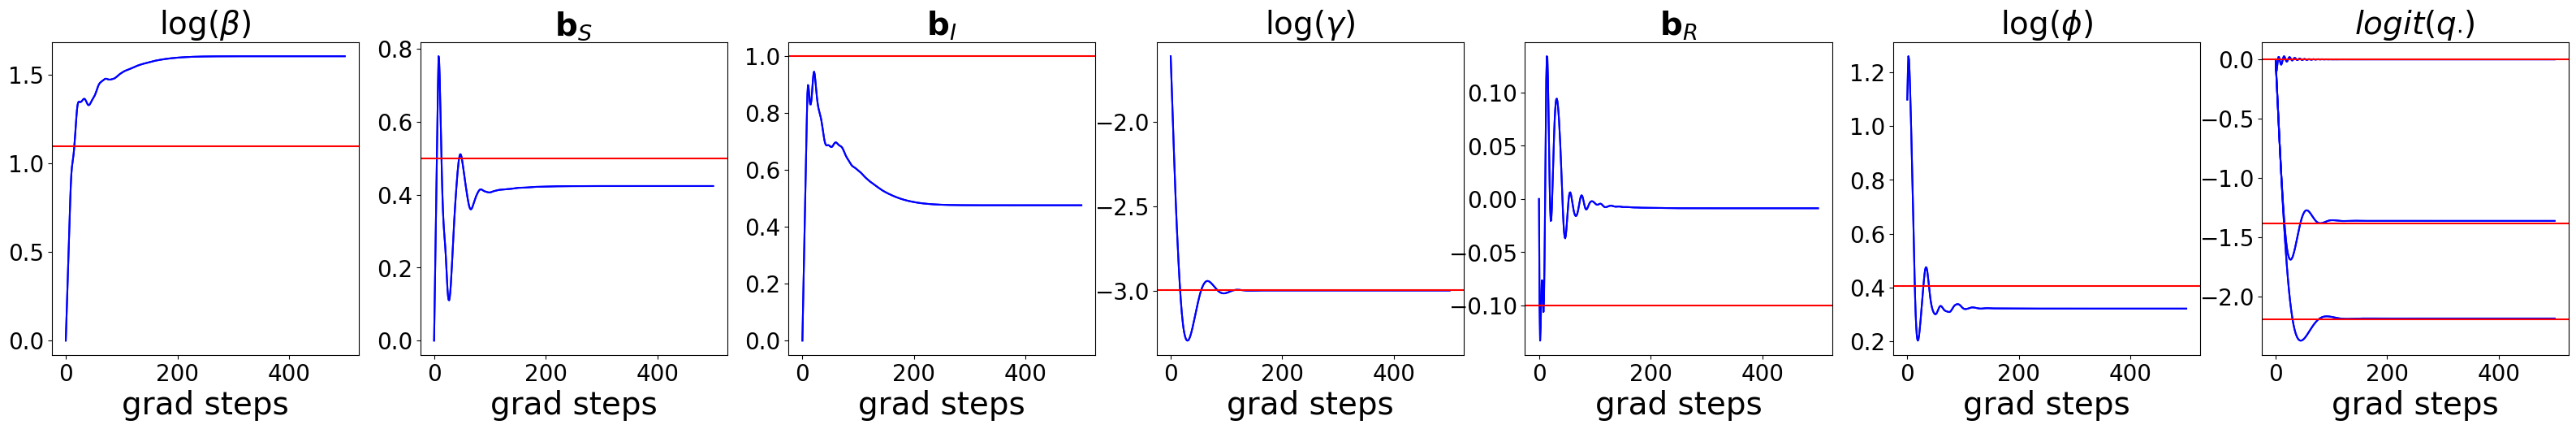

In [50]:
fig, ax = plt.subplots(1, len(learning_parameters), figsize = ((len(learning_parameters)+1)*5, 5))

ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_phi":"$\\log(\\phi)$",
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

counter = -1
for key in learning_parameters.keys():
	
	for i in range(learning_parameters[key]):
		ax[counter+1].set_title(ylabel_dict[key])
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")
		ax[counter+1].set_xlabel("grad steps")

	counter = counter +1

In [51]:
parameters_optimized = {}

for key in parameters.keys():

	if key in parameters_tensor.keys():
		parameters_optimized[key] = parameters_tensor[key][-1,...]

	else:
		parameters_optimized[key] = parameters[key]

Pi_spatial, Mu_spatial, _ = CAL(SIR, parameters_optimized, Y_spatial)

In [52]:
def dummy_classififer(X, Y, prob):

	if prob == "random":
		X_propagate_pred = np.zeros(tf.shape(X))

		current_state = (np.ones(X_propagate_pred[0,...].shape)/3)
		X_propagate_pred[0,...] = current_state
		for t in range(1, T+1):

			X_propagate_pred[t,...] = current_state

	else:
		X_propagate_pred = np.zeros(tf.shape(X))

		current_state = (np.ones(X_propagate_pred[0,...].shape)/3)
		X_propagate_pred[0,...] = current_state
		for t in range(1, T+1):

			observed_individuals = tf.expand_dims(tf.cast(Y[t-1,:,0]==0, dtype = tf.float32), axis = -1)

			normalized_Y = prob*Y[t-1,:,1:] + ((1-prob)/2)*(1-Y[t-1,:,1:])
			# normalized_Y = normalized_Y/tf.reduce_sum(normalized_Y, axis = -1, keepdims=True)

			current_state = current_state*(1-observed_individuals) + normalized_Y*(observed_individuals)

			X_propagate_pred[t,...] = current_state

	return X_propagate_pred


In [53]:
X_random_pred = dummy_classififer(X_spatial, Y_spatial, "random")
X_propagate_pred = dummy_classififer(X_spatial, Y_spatial, 0.34)
X_propagate_pred_certain = dummy_classififer(X_spatial, Y_spatial, 0.99)

In [54]:
from tabulate import tabulate

table = []
 
head = ["Metric", "Random", "Prev. uncertain", "Prev. certain", "CAL"]

row_1 = ["Categorical log-likelihood",  tf.reduce_mean(tf.math.log(tf.reduce_sum(X_spatial*X_random_pred, axis = -1))).numpy(), 
					tf.reduce_mean(tf.math.log(tf.reduce_sum(X_spatial*X_propagate_pred, axis = -1))).numpy(),
					tf.reduce_mean(tf.math.log(tf.reduce_sum(X_spatial*X_propagate_pred_certain, axis = -1))).numpy(),
					tf.reduce_mean(tf.math.log(tf.reduce_sum(X_spatial*Pi_spatial, axis = -1))).numpy()]

row_2 = ["Accuracy",    100*np.sum(X_spatial*tf.one_hot(tf.math.argmax(X_random_pred, axis = -1), 3))/np.prod(X_spatial.shape[:2]),
			100*np.sum(X_spatial*tf.one_hot(tf.math.argmax(X_propagate_pred, axis = -1), 3))/np.prod(X_spatial.shape[:2]),
			100*np.sum(X_spatial*tf.one_hot(tf.math.argmax(X_propagate_pred_certain, axis = -1), 3))/np.prod(X_spatial.shape[:2]),
			100*np.sum(X_spatial*tf.one_hot(tf.math.argmax(Pi_spatial, axis = -1), 3))/np.prod(X_spatial.shape[:2])]
 
table.append(row_1)
table.append(row_2)

# Misspecified model

In [55]:
centroids  = np.load("Data/SpatialInference/Input/centroids.npy")
city_index = np.load("Data/SpatialInference/Input/city_index.npy")

index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N_pop], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates  = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)
communities = tf.gather(city_index, index, axis = 0)

mean_distances = np.zeros(np.unique(communities).shape[0])
for i in range(np.unique(communities).shape[0]):
	
	geo_loc = tf.gather( locations, np.where(communities[:,0] == np.unique(communities)[i])[0], axis = 0).numpy()
	distances = pdist(geo_loc)
	mean_distances[i] = distances.mean()

mean_distances = tf.expand_dims(tf.convert_to_tensor(mean_distances, dtype = tf.float32), axis = 1)

city_covariates = tf.concat((centroids, mean_distances), axis = -1)

_, populations = np.unique(communities, return_counts=True)

SIR_misp = sbm_SIR(city_covariates, communities, covariates, observed_index)

In [56]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([1.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([0.0], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([3], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32))}

learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":3} 

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

loss_tensor, parameters_tensor = CAL_inference(SIR_misp, par_to_upd, Y_spatial, learning_parameters, optimizer, n_gradient_steps, initialization = "parameters")

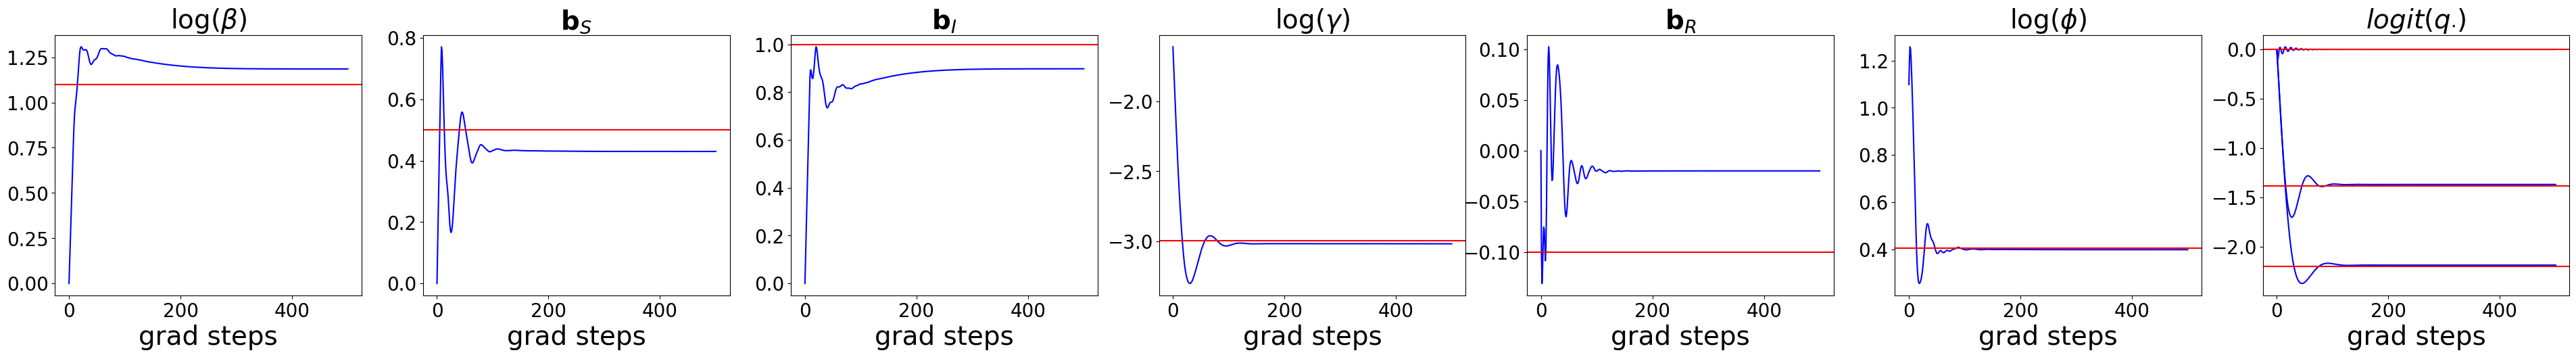

In [57]:
fig, ax = plt.subplots(1, len(learning_parameters), figsize = ((len(learning_parameters)+1)*6, 5))

ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"log_phi":"$\\log(\\phi)$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

counter = -1
for key in learning_parameters.keys():
	
	for i in range(learning_parameters[key]):
		ax[counter+1].set_title(ylabel_dict[key])
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")
		ax[counter+1].set_xlabel("grad steps")

	counter = counter +1

In [58]:
parameters_optimized = {}

for key in parameters.keys():

	if key in parameters_tensor.keys():
		parameters_optimized[key] = parameters_tensor[key][-1,...]

	else:
		parameters_optimized[key] = parameters[key]

Pi_graph, Mu_graph, _ = CAL(SIR_misp, parameters_optimized, Y_spatial)

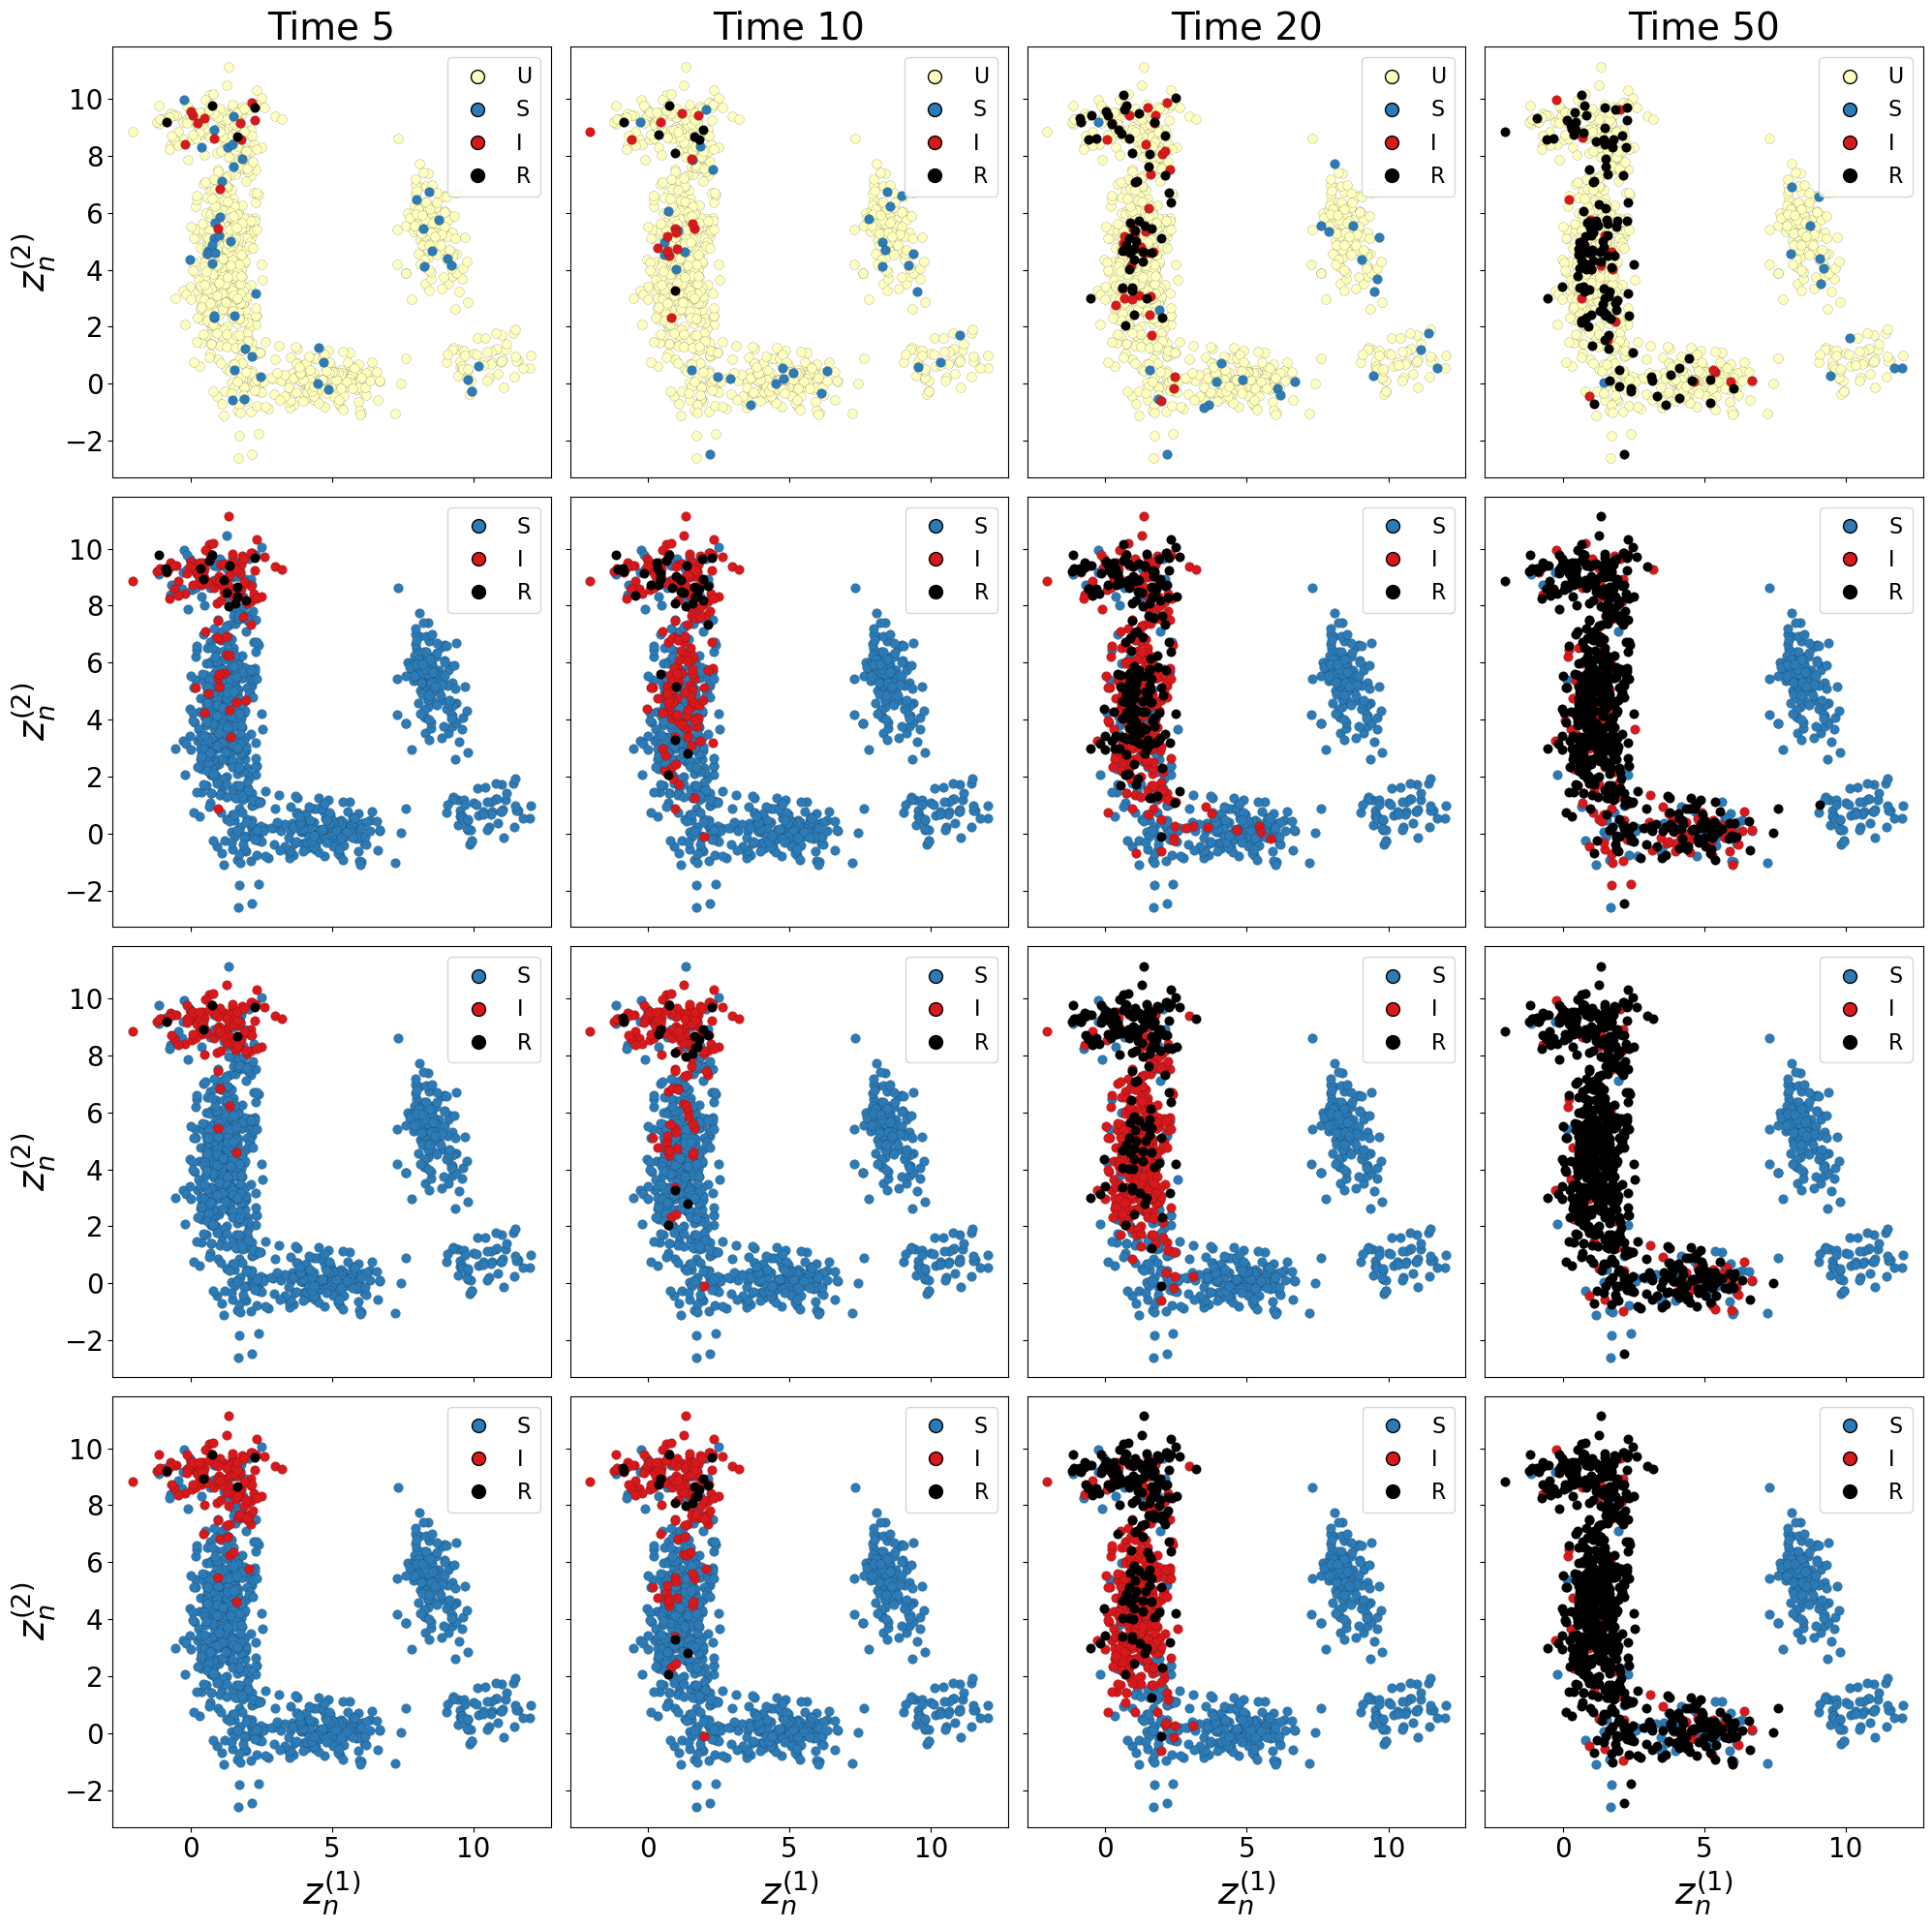

In [59]:
fig, ax = plt.subplots(4, 4, figsize = (20, 20), sharex=True, sharey=True)

time_list = [5, 10, 20, 50]

ax[0, 0].set_ylabel(r"$z_n^{(2)}$")
ax[1, 0].set_ylabel(r"$z_n^{(2)}$")
ax[2, 0].set_ylabel(r"$z_n^{(2)}$")
ax[3, 0].set_ylabel(r"$z_n^{(2)}$")

s_size = 50

for j in range(4):

	t = time_list[j]
	
	ax[0, j].set_title("Time "+str(t))

	loc_y_unrepor = tf.gather(locations, tf.where(Y_spatial[t-1,:,0]==1)[:,0], axis = 0)
	loc_y_suscept = tf.gather(locations, tf.where(Y_spatial[t-1,:,1]==1)[:,0], axis = 0)
	loc_y_infecte = tf.gather(locations, tf.where(Y_spatial[t-1,:,2]==1)[:,0], axis = 0)
	loc_y_removed = tf.gather(locations, tf.where(Y_spatial[t-1,:,3]==1)[:,0], axis = 0)

	ax[0, j].scatter(loc_y_unrepor[:,0], loc_y_unrepor[:,1], color = "#ffffbf", s = s_size, edgecolors='black', linewidths=0.1 )
	ax[0, j].scatter(loc_y_suscept[:,0], loc_y_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[0, j].scatter(loc_y_infecte[:,0], loc_y_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	ax[0, j].scatter(loc_y_removed[:,0], loc_y_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#ffffbf", markeredgecolor='black', markersize=10, label="U"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[0, j].legend(handles=legend_handles, loc = "upper right", fontsize = 16)

	infected = tf.where(X_spatial[t,:,1]==1)[:,0]

	loc_suscept = tf.gather(locations, tf.where(X_spatial[t,:,0]==1)[:,0], axis = 0)
	loc_infecte = tf.gather(locations, tf.where(X_spatial[t,:,1]==1)[:,0], axis = 0)
	loc_removed = tf.gather(locations, tf.where(X_spatial[t,:,2]==1)[:,0], axis = 0)

	ax[1, j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[1, j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	ax[1, j].scatter(loc_removed[:,0], loc_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),	
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[1, j].legend(handles=legend_handles, loc = 1, fontsize = 16)

	CAL_prediction = tf.one_hot(tf.math.argmax(Pi_spatial, axis = -1), 3)
	loc_suscept_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,0]==1)[:,0], axis = 0)
	loc_infecte_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,1]==1)[:,0], axis = 0)
	loc_removed_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,2]==1)[:,0], axis = 0)

	ax[2, j].scatter(loc_suscept_Pi[:,0], loc_suscept_Pi[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1) 
	ax[2, j].scatter(loc_infecte_Pi[:,0], loc_infecte_Pi[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1) 
	ax[2, j].scatter(loc_removed_Pi[:,0], loc_removed_Pi[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1) 

	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[2, j].legend(handles=legend_handles, loc = 1, fontsize = 16)

	CAL_prediction = tf.one_hot(tf.math.argmax(Pi_graph, axis = -1), 3)
	loc_suscept_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,0]==1)[:,0], axis = 0)
	loc_infecte_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,1]==1)[:,0], axis = 0)
	loc_removed_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,2]==1)[:,0], axis = 0)

	ax[3, j].scatter(loc_suscept_Pi[:,0], loc_suscept_Pi[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1) 
	ax[3, j].scatter(loc_infecte_Pi[:,0], loc_infecte_Pi[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1) 
	ax[3, j].scatter(loc_removed_Pi[:,0], loc_removed_Pi[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1) 
	
	ax[3, j].set_xlabel(r"$z_n^{(1)}$")

	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[3, j].legend(handles=legend_handles, loc = 1, fontsize = 16)

plt.tight_layout()

In [61]:
row_1.append(tf.reduce_mean(tf.math.log(tf.reduce_sum(X_spatial*Pi_graph, axis = -1))).numpy())
row_2.append(100*np.sum(X_spatial*tf.one_hot(tf.math.argmax(Pi_graph, axis = -1), 3))/np.prod(X_spatial.shape[:2]))

head.append("CAL misspecified")

table = []
table.append(row_1)
table.append(row_2)

print(tabulate(table, headers=head, tablefmt="latex_raw"))

\begin{tabular}{lrrrrrr}
\hline
 Metric                     &   Random &   Prev. uncertain &   Prev. certain &     CAL &   CAL misspecified &   CAL misspecified \\
\hline
 Categorical log-likelihood & -1.09861 &          -1.08996 &       -0.672639 & -0.2844 &          -0.291198 &          -0.291198 \\
 Accuracy                   & 34.8485  &          65.2812  &       65.2812   & 88.4752 &          88.0752   &          88.0752   \\
\hline
\end{tabular}
